In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model, models, layers, optimizers, regularizers
from sklearn import metrics
from sklearn.model_selection import train_test_split

#판다스 데이터 불러오기
df_fault = pd.read_csv('dataset/outlier_data.csv')
df_nor = pd.read_csv('dataset/press_data_normal.csv')

#데이터 copy
normal = df_nor.copy()
outlier = df_fault.copy()

#정상데이터 시각화 + use_col 활요하여 독립변수 추출
use_col = ['AI0_Vibration', 'AI1_Vibration', 'AI2_Current']
# plt.figure(figsize=(30, 15))
# for i in range(len(use_col)):
#     plt.subplot(3, 1, i+1)
#     plt.title(use_col[i], fontsize=30)
#     plt.plot(normal[use_col[i]])
#     plt.xticks(size=20)
#     plt.yticks(size=20)

# plt.tight_layout()

#이상데이터 시각화
# plt.figure(figsize=(30, 15))
# for i in range(len(use_col)):
#     plt.subplot(3, 1, i+1)
#     plt.title(use_col[i], fontsize=30)
#     plt.plot(outlier[use_col[i]])
#     plt.xticks(size=20)
#     plt.yticks(size=20)

# plt.tight_layout()

#apply 활용하여 함수 적용
normal[use_col] = normal[use_col].apply(lambda x: abs(x))
outlier[use_col] = outlier[use_col].apply(lambda x: abs(x))


# plt.figure(figsize=(30, 15))
# for i in range(len(use_col)):
#     plt.subplot(3, 1, i+1)
#     plt.title(use_col[i], fontsize=30)
#     plt.plot(normal[use_col[i]])
#     plt.xticks(size=20)
#     plt.yticks(size=20)

# plt.tight_layout()

# #이상데이터 시각화
# plt.figure(figsize=(30, 15))
# for i in range(len(use_col)):
#     plt.subplot(3, 1, i+1)
#     plt.title(use_col[i], fontsize=30)
#     plt.plot(outlier[use_col[i]])
#     plt.xticks(size=20)
#     plt.yticks(size=20)

# 입력데이터, 타겟데이터 분류.
X_normal = normal[use_col]
y_normal = normal['Equipment_state']
X_anomaly = outlier[use_col]
y_anomaly = outlier['Equipment_state']

# 데이터 split
X_train_normal = X_normal[:15000]
y_train_normal = y_normal[:15000]
X_test_normal = X_normal[15000:]
y_test_normal = y_normal[15000:]
X_test_anomaly = X_anomaly
y_test_anomaly = y_anomaly

# 입력변수 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_normal_scaled = scaler.transform(X_test_normal)
X_test_anomaly_scaled = scaler.transform(X_test_anomaly)

# 종속변수 list -> numpy배열 변경
y_train_normal = np.array(y_train_normal)
y_test_normal = np.array(y_test_normal)
y_test_anomaly = np.array(y_test_anomaly)

# sequence 초기화
sequence = 20

# 미래데이터 예측을 위해서 offset 설정
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence - 100):
    X_train.append(X_train_scaled[index: index + sequence])
    Y_train.append(y_train_normal[index + sequence + 100])


X_test_normal, Y_test_normal = [], []
for index in range(len(X_test_normal_scaled) - sequence - 100):
    X_test_normal.append(X_test_normal_scaled[index: index + sequence])
    Y_test_normal.append(y_test_normal[index + sequence + 100])

X_test_anomal, Y_test_anomal = [], []
for index in range(len(X_test_anomaly_scaled) - sequence - 100):
    X_test_anomal.append(X_test_anomaly_scaled[index: index + sequence])
    Y_test_anomal.append(y_test_anomaly[index + sequence + 100])

# 데이터 split
X_test_normal, Y_test_normal = np.array(X_test_normal), np.array(Y_test_normal)
X_test_anomal, Y_test_anomal = np.array(X_test_anomal), np.array(Y_test_anomal)

X_valid_normal, Y_valid_normal = X_test_normal[:880, :, :], Y_test_normal[:880]
X_test_normal, Y_test_normal = X_test_normal[880:, :, :], Y_test_normal[880:]
X_valid_anomal, Y_valid_anomal = X_test_anomal[:300, :, :], Y_test_anomal[:300]
X_test_anomal, Y_test_anomal = X_test_anomal[300:, :, :], Y_test_anomal[300:]

# 데이터 concat개념으로 보면 이해가 됨.
X_valid = np.vstack((X_valid_normal, X_valid_anomal))
Y_valid = np.hstack((Y_valid_normal, Y_valid_anomal))

X_test = np.vstack((X_test_normal, X_test_anomal))
Y_test= np.hstack((Y_test_normal, Y_test_anomal))

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)
X_test, Y_test = np.array(X_test), np.array(Y_test)

print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_valid:', X_valid.shape, 'Y_valid:', Y_valid.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_valid_0 = X_valid[Y_valid==0]

def LSTM_AE(sequence, n_features):
    lstm_ae = models.Sequential()

    lstm_ae.add(layers.LSTM(64, input_shape=(sequence, n_features), return_sequences=True))
    lstm_ae.add(layers.LSTM(32, return_sequences=False))
    lstm_ae.add(layers.RepeatVector(sequence))

    lstm_ae.add(layers.LSTM(32, return_sequences=True))
    lstm_ae.add(layers.LSTM(64, return_sequences=True))
    lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))
    return lstm_ae

lstm_ae = LSTM_AE(20, 3)
lstm_ae.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=50, verbose=1)
es = EarlyStopping(monitor='val_loss', min_delta = 0.00001, patience=120, verbose=1, mode='min', restore_best_weights=True)

lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(0.001))

history = lstm_ae.fit(X_train, X_train, epochs = 800, batch_size = 128, callbacks = [reduce_lr, es], validation_data = (X_valid_0, X_valid_0))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch');plt.ylabel('loss')
plt.show()

def flatten(X):
    flattened = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened[i] = X[i, X.shape[1] - 1, :]
    return flattened
    
valid_x_predictions = lstm_ae.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)

precision, recall, threshold = metrics.precision_recall_curve(list(Y_valid), mse)
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision, recall)) if p == r][0]
threshold_final = threshold[index_cnt]

plt.figure(figsize=(10, 7))
plt.title("Precision/Recall Curve for threshold", fontsize = 15)
plt.plot(threshold[threshold <= 0.2], precision[1:][threshold <= 0.2], label='Precision')
plt.plot(threshold[threshold <= 0.2], recall[1:][threshold <= 0.2], label="Recall")
plt.plot(threshold_final, precision[index_cnt], 'o', color='r', label='Optimal threshold')
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend()
plt.show()

print("precision: ", precision[index_cnt], ', recall:', recall[index_cnt])
print('threshold: ', threshold_final)

test_x_predictions = lstm_ae.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis = 1)
plt.figure(figsize=(10, 7))
plt.title("Reconstruction Error for both classes", fontsize=15)
plt.plot(np.where(Y_test==0)[0], mse[Y_test==0], marker='o', linestyle='', label = "Normal")
plt.plot(np.where(Y_test==1)[0], mse[Y_test==1], marker='o', linestyle='', label = 'Anomaly')
plt.axhline(threshold_final, 0, len(Y_test), color = 'r', linestyle='--', label='Threshold for Anomaly')
plt.legend()
plt.ylabel("Reconstruction Error")
plt.show()

pred_y = [1 if e > threshold_final else 0 for e in mse]

conf_matrix = metrics.confusion_matrix(list(Y_test), pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

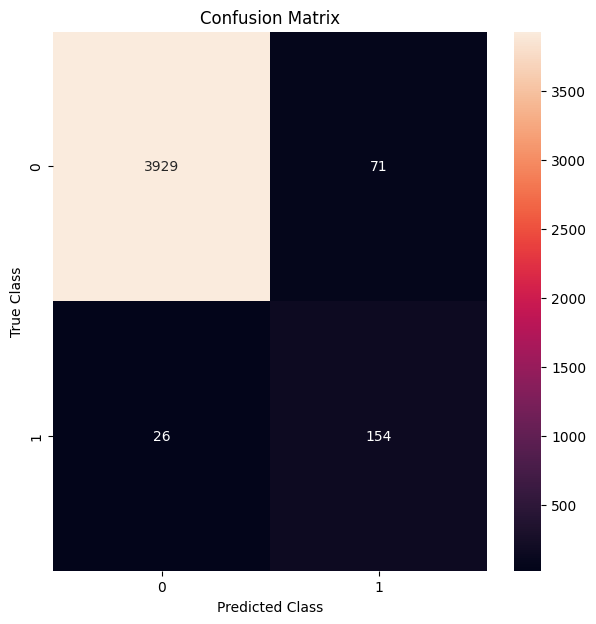

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --------------------------
# 1. 데이터 로드
# --------------------------
df_fault = pd.read_csv('dataset/outlier_data.csv')
df_nor = pd.read_csv('dataset/press_data_normal.csv')

use_col = ['AI0_Vibration', 'AI1_Vibration', 'AI2_Current']

# 절댓값 처리
df_nor[use_col] = df_nor[use_col].abs()
df_fault[use_col] = df_fault[use_col].abs()

# Feature / Label
X_normal = df_nor[use_col]
y_normal = df_nor['Equipment_state']
X_anomaly = df_fault[use_col]
y_anomaly = df_fault['Equipment_state']

# --------------------------
# 2. 데이터 합치기
# --------------------------
X_all = pd.concat([X_normal, X_anomaly], axis=0).reset_index(drop=True)
y_all = pd.concat([y_normal, y_anomaly], axis=0).reset_index(drop=True)

# --------------------------
# 3. Train/Validation/Test 분리
# --------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42, stratify=y_all
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42, stratify=y_temp
)

# --------------------------
# 4. MinMaxScaler
# --------------------------
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# 5. 시퀀스 생성 함수
# --------------------------
def make_sequences(X, y, sequence=20, offset=100):
    X_seq, Y_seq = [], []
    max_index = len(X) - sequence - offset
    if max_index <= 0:
        return np.empty((0, sequence, X.shape[1])), np.empty((0,))
    for i in range(max_index):
        X_seq.append(X[i:i+sequence])
        Y_seq.append(y[i + sequence + offset])
    return np.array(X_seq), np.array(Y_seq)

sequence = 20
offset = 100

X_train_seq, Y_train_seq = make_sequences(X_train_scaled, np.array(y_train), sequence, offset)
X_valid_seq, Y_valid_seq = make_sequences(X_valid_scaled, np.array(y_valid), sequence, offset)
X_test_seq, Y_test_seq = make_sequences(X_test_scaled, np.array(y_test), sequence, offset)

# --------------------------
# 6. 데이터 shape 확인
# --------------------------
print('X_train:', X_train_seq.shape, 'Y_train:', Y_train_seq.shape)
print('X_valid:', X_valid_seq.shape, 'Y_valid:', Y_valid_seq.shape)
print('X_test:', X_test_seq.shape, 'Y_test:', Y_test_seq.shape)

# --------------------------
# 7. LSTM Autoencoder 정의
# --------------------------
def LSTM_AE(sequence, n_features):
    lstm_ae = models.Sequential()
    # 인코더
    lstm_ae.add(layers.LSTM(64, input_shape=(sequence, n_features), return_sequences=True))
    lstm_ae.add(layers.LSTM(32, return_sequences=False))
    lstm_ae.add(layers.RepeatVector(sequence))
    # 디코더
    lstm_ae.add(layers.LSTM(32, return_sequences=True))
    lstm_ae.add(layers.LSTM(64, return_sequences=True))
    lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))
    return lstm_ae

lstm_ae = LSTM_AE(sequence, X_train_seq.shape[2])
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(0.001))

# --------------------------
# 8. Callback 정의
# --------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=20, verbose=1)
es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1,
                   mode='min', restore_best_weights=True)

# --------------------------
# 9. 학습
# --------------------------
# Autoencoder 학습: 입력=출력
history = lstm_ae.fit(
    X_train_seq, X_train_seq,
    epochs=500,
    batch_size=128,
    validation_data=(X_valid_seq, X_valid_seq),
    callbacks=[reduce_lr, es]
)


X_train: (14300, 20, 3) Y_train: (14300,)
X_valid: (2970, 20, 3) Y_valid: (2970,)
X_test: (2970, 20, 3) Y_test: (2970,)


/home/mymeta_corp/.pyenv/versions/tf_gpu_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0126 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 2/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0107 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 3/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0104 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 4/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0102 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 5/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0101 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 6/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0099 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 7/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0097 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 8/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0097 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 9/500
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0097 - val_loss: 0.0095 - learning_rat